In [50]:
from astropy.io import fits
import glob
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import astropy.units as u
from photutils.centroids import centroid_com
from photutils import CircularAperture, CircularAnnulus,aperture_photometry
from photutils.detection import DAOStarFinder
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from photutils.utils import calc_total_error
from astropy.stats import sigma_clip
from astropy.table import Table
import pandas as pd
import uncertainties
from matplotlib.colors import LogNorm
from scipy.interpolate import UnivariateSpline
from astropy.stats import sigma_clipped_stats
from photutils.centroids import centroid_sources

In [51]:
def bias_subtract(data):
    new_data = np.empty(data.shape)
    for i in range(data.shape[1]):  # Loop over columns
        overscan_data = data[-16:, i]
        overscan_median = np.median(overscan_data)
        new_data[:, i] = data[:, i] - overscan_median  # Subtract overscan_median from each column

    return new_data

Downloads/tmodata\CCD Image 126.fit


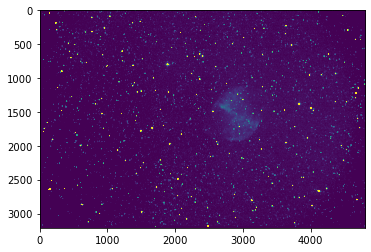

Downloads/tmodata\CCD Image 127.fit


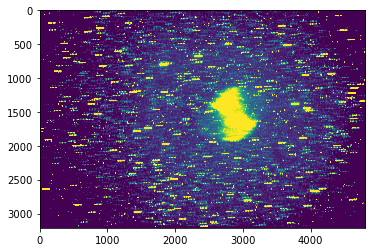

Downloads/tmodata\CCD Image 128.fit


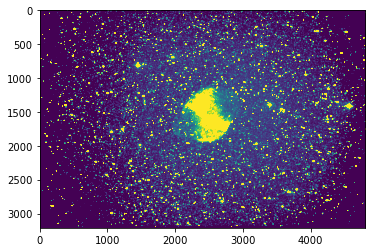

Downloads/tmodata\CCD Image 129.fit


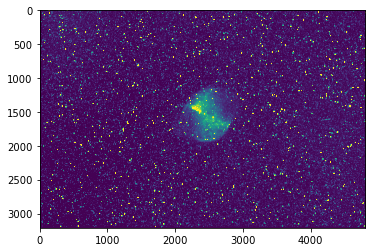

Downloads/tmodata\CCD Image 130.fit


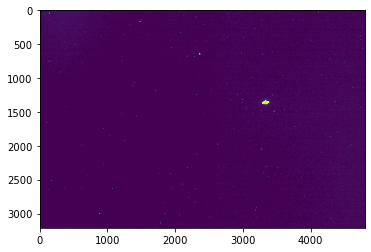

Downloads/tmodata\CCD Image 131.fit


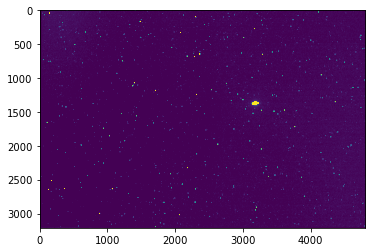

Downloads/tmodata\CCD Image 132.fit


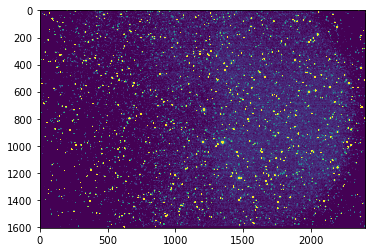

Downloads/tmodata\CCD Image 133.fit


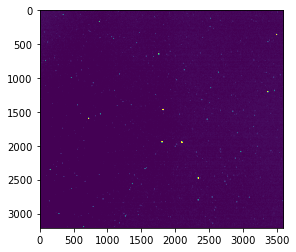

Downloads/tmodata\CCD Image 134.fit


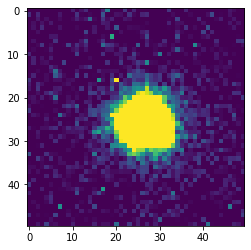

Downloads/tmodata\CCD Image 135.fit


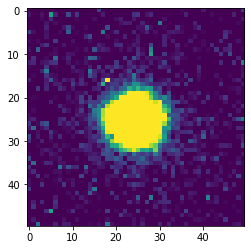

In [52]:
d = 'Downloads/'
files = glob.glob(d+'tmodata/*')

for i in files:
    print(i)
    image = fits.open(i)
    data = image[0].data
    plt.imshow(data,vmin=np.median(data),vmax=np.median(data)+100)
    plt.show()

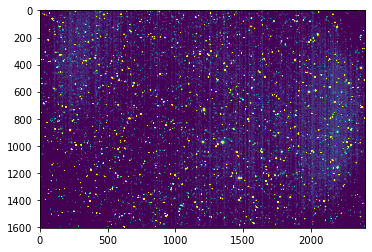

In [91]:
image = fits.open(files[6])
data = image[0].data
data = np.float64(data)
header = image[0].header
b_data = bias_subtract(data)

plt.imshow(b_data,vmin=np.median(b_data),vmax=np.median(b_data)+100)

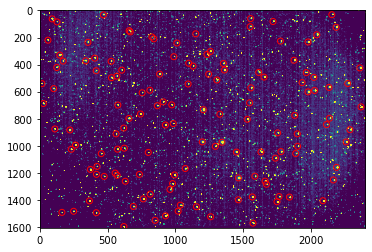

In [92]:
daofind = DAOStarFinder(threshold=5000,fwhm=4)
sources = daofind(b_data)

plt.imshow(b_data,vmin=np.median(b_data),vmax=np.median(b_data)+100)
plt.scatter(sources['xcentroid'],sources['ycentroid'],facecolor='none',edgecolor='red')

In [93]:
def profiles(data,xcenter,ycenter):
    ypix, xpix = ycenter,xcenter
    x = np.take(data, ypix, axis=0)[int(xcenter)-25:int(xcenter)+25]
    y = np.take(data, xpix, axis=1)[int(ycenter)-25:int(ycenter)+25]
    return x, y

def interpolate_width(axis,background):
    peak = axis.max()    
    half_max = (peak-background)/2
    x = np.linspace(0, len(axis), len(axis))
    # Do the interpolation
    spline = UnivariateSpline(x, axis-background-half_max, s=0)
    r1, r2 = spline.roots()
    return r1,r2,r2-r1

def GetFWHM(data,sources,makeplot):   
    '''
    It returns the median FWHM of a bunch of stars

    makeplot: 'True' or 'False' for make plots for each stars flux profile. change it to 'False' if youre doing like 1000 stars 
    '''    

    mean, median, std = sigma_clipped_stats(data, sigma=3.0)
    background = median
       
    xlist = (np.array(sources['xcentroid']))
    ylist = (np.array(sources['ycentroid']))
    
    xlist, ylist = centroid_sources(data, xlist, ylist, box_size=25,
                centroid_func=centroid_com)
    
    FWHM = []
    for ID in range(len(xlist)):

        xcenter,ycenter = xlist[ID],ylist[ID]
        
        try:
            horizontal, vertical = profiles(data,xcenter,ycenter)      
            r1h,r2h,fwhm_x = interpolate_width(horizontal,background)
            r1v,r2v,fwhm_y = interpolate_width(vertical,background)            
            fwhm_inst = np.mean([fwhm_x,fwhm_y])
            FWHM = np.append(FWHM,fwhm_inst)
            
            if makeplot==True:
                xx = np.arange(0,len(vertical),1)
                hor_half = ((horizontal-background).max())/2
                ver_half = ((vertical-background).max())/2
                
                fig,(ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(10,4))
                
                ax1.imshow(data[int(ycenter)-25:int(ycenter)+25,int(xcenter)-25:int(xcenter)+25],norm=LogNorm(),origin='lower')
                ax1.axvline(25, color='red', linestyle='dashed',alpha=0.8)
                ax1.axhline(25, color='red', linestyle='dashed',alpha=0.8)
                
                ax2.plot(xx,vertical-background)
                ax2.hlines(ver_half,color='red',xmin=r1v,xmax=r2v)
                ax2.set_title('Vertical Cross Section')
                ax2.set_xlabel('FWHM= '+str(np.round(fwhm_y,2)))
                
                ax3.plot(xx,horizontal-background)
                ax3.set_title('Horizontal Cross Section')
                ax3.hlines(hor_half,color='red',xmin=r1h,xmax=r2h)
                ax3.set_title('Horizontal Cross Section')
                ax3.set_xlabel('FWHM= '+str(np.round(fwhm_x,2)))                
                plt.show()    
                #plt.savefig('FWHM example.pdf',bbox_inches='tight',facecolor='white')
        except:
            pass       
    median_FWHM = np.median(FWHM)
    plt.hist(FWHM,bins='auto')
    plt.axvline(median_FWHM, color='red', linestyle='dashed')
    plt.xlabel(str(len(FWHM))+' FWHMs calculated \n Median FWHM: '+str(np.round(median_FWHM,2)),size=13)
    
    #plt.show()
    plt.savefig('FWHM median.pdf',bbox_inches='tight',facecolor='white')
    print('Median FWHM: '+str(np.round(median_FWHM,2)))
    return median_FWHM

Median FWHM: 2.05


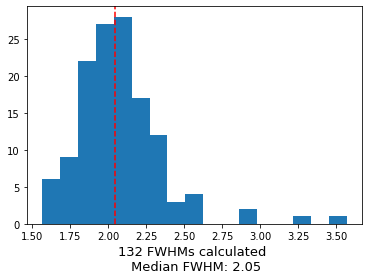

In [94]:
median_FWHM = GetFWHM(data=data,sources=sources,makeplot=False)

# Aperture Photometry

In [154]:
xcentroid = np.array(sources['xcentroid'])
ycentroid = np.array(sources['ycentroid'])
source_positions = np.column_stack((xcentroid, ycentroid))


aperture = CircularAperture(source_positions, r=median_FWHM)
annulus = CircularAnnulus(source_positions, r_in=median_FWHM+2, r_out=median_FWHM+5)

phot_aper = [aperture, annulus]

filtered_data = sigma_clip(data, sigma=3., copy=False)
bkg_values_nan = filtered_data.filled(fill_value=np.nan)
bkg_error = np.sqrt(bkg_values_nan)
bkg_error[np.isnan(bkg_error)] = np.nanmedian(bkg_error)

unc_data = calc_total_error(data, bkg_error,effective_gain=1) 

phot_table = aperture_photometry(data, phot_aper, error=unc_data)

bkg_mean = phot_table['aperture_sum_1'] / annulus.area
bkg_ap_sum = bkg_mean * aperture.area
final_sum = phot_table['aperture_sum_0']-bkg_ap_sum
phot_table['bg_subtracted_counts'] = final_sum
bkg_mean_err = phot_table['aperture_sum_err_1'] / annulus.area
bkg_sum_err = bkg_mean_err * aperture.area
phot_table['bg_sub_cts_err'] = np.sqrt((phot_table['aperture_sum_err_0']**2)+(bkg_sum_err**2)) 

phot_table['Instr_Mag'] = -2.5*np.log10(phot_table['bg_subtracted_counts']/header['EXPTIME'])

phot_table['Instr_Mag_err'] = np.abs((-5/(2*np.log(10)))*(header['EXPTIME']
                                                          /phot_table['bg_subtracted_counts'])*phot_table['bg_sub_cts_err'])

In [155]:
phot_table

id,xcenter,ycenter,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1,bg_subtracted_counts,bg_sub_cts_err,Instr_Mag,Instr_Mag_err
,pix,pix,,,,,,,,
int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,2155.6217665486756,31.496852535275465,63754.357109668905,304.19906367851235,229549.12907217623,677.3013077944889,34870.882302755446,315.9113686178598,-8.856157340075331,0.09836183880440513
2,469.5233543758807,32.70155318958849,129968.3607564296,398.4350810324567,232679.04241039205,681.5279545314183,100691.0583910428,407.55903441615743,-10.007477264669864,0.04394646419579699
3,1556.0299400606373,60.18957900893707,96093.11055151364,353.376942644005,232372.05443875276,680.8436014091816,66854.43555701127,363.6129192840819,-9.5628255661689,0.05905183518419823
4,91.3782393271801,62.570980602174544,168732.11791076223,444.42577665080694,232779.05258311756,680.6342840792857,139442.23156687798,452.6023094164477,-10.360985810997565,0.03524088134338947
5,1721.7424597202214,81.73278191364324,55279.827226676054,289.93444132697795,230403.70255112142,678.7887639303322,26288.82401549665,302.2529383304791,-8.549427897844492,0.1248313572134229
6,127.53791861145729,85.04231206400138,52532.44007815501,285.1571375909531,227760.35237546358,675.0215343025035,23874.04164972107,297.5377360572423,-8.44481486795973,0.13531328170523257
7,1552.9202396183719,120.35986273356403,87149.82302608815,340.48785010187794,231480.4679905963,680.1037934282391,58023.33366617128,351.0770952724672,-9.409006692726043,0.06569376299398501
8,2187.6595726347505,124.4978166517304,78823.34382526283,328.03276797627024,230306.8588079221,678.5434089777254,49844.52617030057,338.961771712894,-9.244043679710396,0.07383419922987099
